In [1]:
import torch
import torchvision
from torchvision import transforms,datasets
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.utils import save_image

device = "cuda:0" if torch.cuda.is_available() else "cpu"

data_dir = "data"
print(os.listdir(data_dir))

epochs = 100
batch_size = 200
image_size = 64
learning_rate = 0.0002
sample_dir = "/samples"
latent_size = 100

['Images']


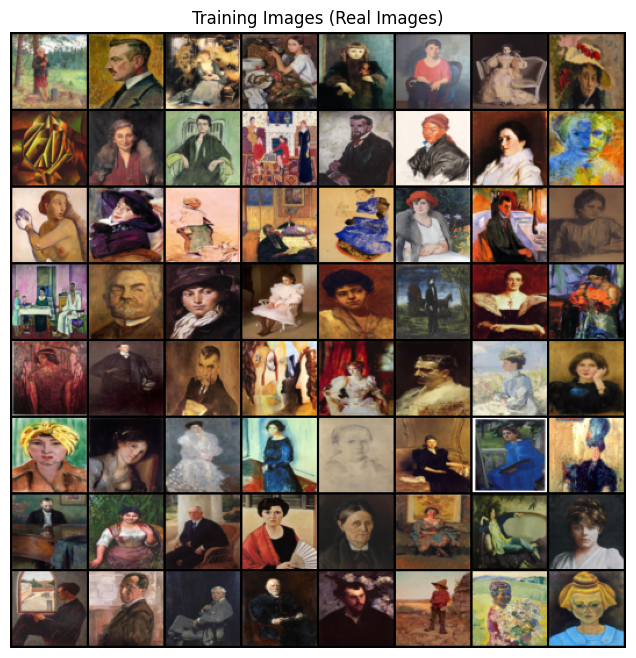

In [2]:

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


transformed_data = transforms.Compose([
    transforms.Resize((image_size)),
    transforms.CenterCrop((image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    ])



dataset = datasets.ImageFolder(data_dir, transform=transformed_data)


dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)

real_images= next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images (Real Images)")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_images[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


In [3]:
"""The Generator trying to get his was and make fake data"""

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size,64 * 8,4,1,0,bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64 * 8, 64 * 4,4,2,1,bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64 * 4, 64 * 2,4,2,1,bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            
            
            nn.ConvTranspose2d(64 * 2, 64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,3,4,2,1,bias=False),
            nn.Tanh()
            )
        
    def forward(self,input):
        return self.main(input)
            
            

G = Generator().to(device)

In [4]:
""" However, the discriminator will not let this happen (he is the good guy)"""


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(64 ,64 * 2, 4,2,1,bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(64 * 2, 64 * 4, 4,2,1,bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2,inplace=True),
            
            nn.Conv2d(64 * 4,64 * 8, 4,2,1,bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2,inplace=True),
            
            
            nn.Conv2d(64 * 8, 1,4,1,0,bias=False),
            nn.Sigmoid()
            )
        
    def forward(self,input):
        return self.main(input)
    
D = Discriminator().to(device)

In [5]:
""" Ok, time for two Neural Netoworks to go to war and argue and burn my gpu"""



D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))


real_label = 1
fake_label = 0


def denorm(x):
    out = (x+1) / 2
    return out
    

criterion = nn.BCELoss()


img_list = []
G_losses = []
D_losses = []
iters = 0



for epoch in range(epochs):

    for i, data in enumerate(dataloader, 0):




        
        D.zero_grad()
  
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = D(real_cpu).view(-1)
  
        errD_real = criterion(output, label)

        errD_real.backward()
        D_x = output.mean().item()


        noise = torch.randn(b_size, latent_size, 1, 1, device=device)

        fake = G(noise)
        label.fill_(fake_label)

        output = D(fake.detach()).view(-1)

        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake

        D_optimizer.step()


        G.zero_grad()
        label.fill_(real_label)  
       
        output = D(fake).view(-1)

        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()

        G_optimizer.step()


        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


        G_losses.append(errG.item())
        D_losses.append(errD.item())



        iters += 1

[0/100][0/29]	Loss_D: 1.4313	Loss_G: 3.0993	D(x): 0.4567	D(G(z)): 0.4613 / 0.0473
[1/100][0/29]	Loss_D: 0.2480	Loss_G: 15.3347	D(x): 0.8220	D(G(z)): 0.0000 / 0.0000
[2/100][0/29]	Loss_D: 0.2412	Loss_G: 10.3305	D(x): 0.8238	D(G(z)): 0.0017 / 0.0001
[3/100][0/29]	Loss_D: 0.6358	Loss_G: 1.7996	D(x): 0.7786	D(G(z)): 0.2797 / 0.2530
[4/100][0/29]	Loss_D: 0.7289	Loss_G: 1.6150	D(x): 0.6543	D(G(z)): 0.2369 / 0.2036
[5/100][0/29]	Loss_D: 0.7221	Loss_G: 2.8536	D(x): 0.7640	D(G(z)): 0.3433 / 0.0672
[6/100][0/29]	Loss_D: 0.5859	Loss_G: 2.8201	D(x): 0.8620	D(G(z)): 0.3186 / 0.0771
[7/100][0/29]	Loss_D: 0.6196	Loss_G: 4.1642	D(x): 0.7438	D(G(z)): 0.2006 / 0.0251
[8/100][0/29]	Loss_D: 0.4282	Loss_G: 5.1559	D(x): 0.7287	D(G(z)): 0.0258 / 0.0090
[9/100][0/29]	Loss_D: 0.5528	Loss_G: 3.2141	D(x): 0.8431	D(G(z)): 0.2904 / 0.0495
[10/100][0/29]	Loss_D: 0.7101	Loss_G: 5.1044	D(x): 0.9052	D(G(z)): 0.4283 / 0.0106
[11/100][0/29]	Loss_D: 0.9133	Loss_G: 4.5422	D(x): 0.8654	D(G(z)): 0.4916 / 0.0189
[12/100][0/2

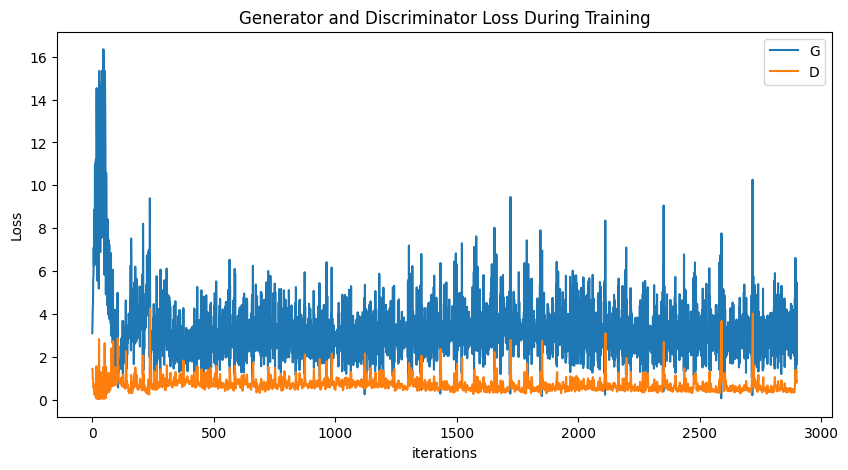

In [6]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
        

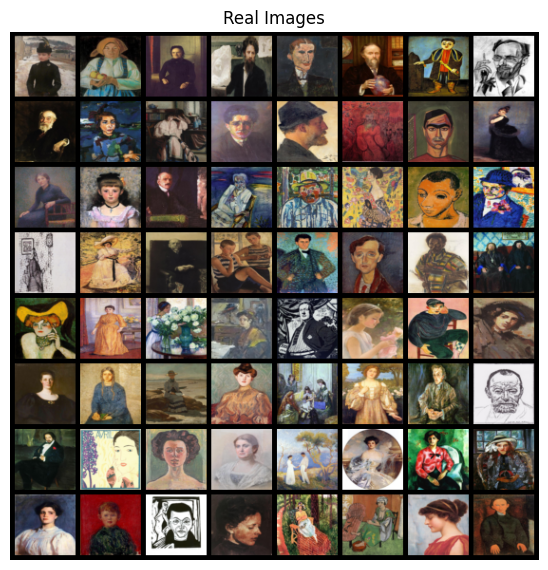

In [7]:
real_batch = next(iter(dataloader))


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5,normalize=True).cpu(),(1,2,0)))
plt.show()

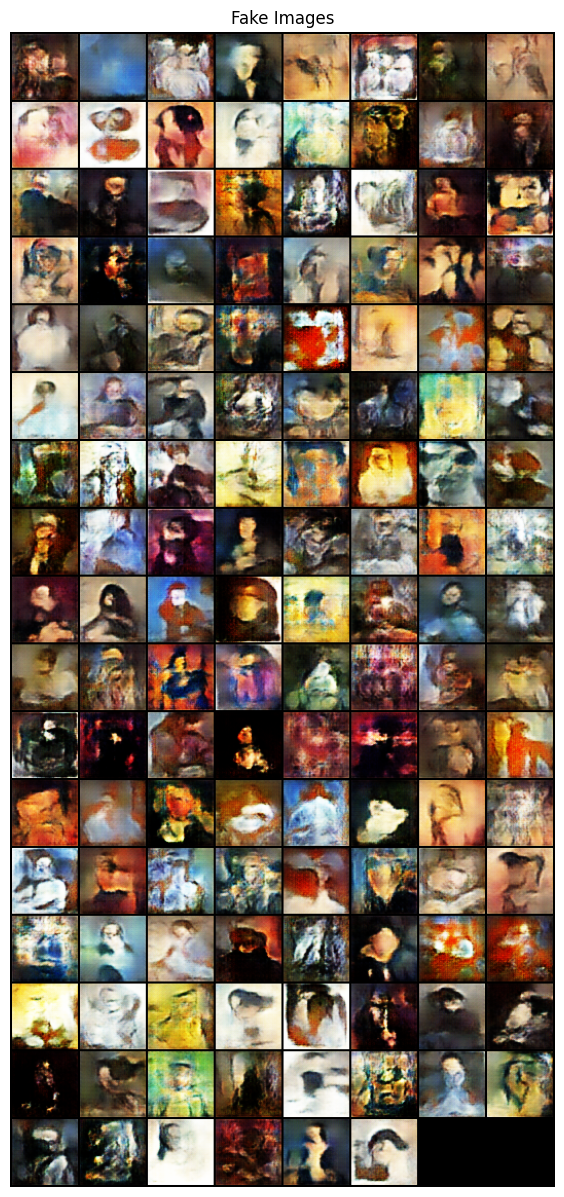

In [9]:

def denorm(x):
    out = (x+1) / 2
    return out.clamp(0,1)


fake_images = denorm(fake)


grid = torchvision.utils.make_grid(fake,padding=2,normalize=True)

plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(grid.cpu(),(1,2,0)))
plt.show()





